# **트레이딩 전략과 구현 6장 포트폴리오 이론**
**[파이썬 증권 데이터 분석 6장](https://nbviewer.jupyter.org/github/INVESTAR/StockAnalysisInPython/tree/master/06_Trading_Strategy/)**
 | **[nbviewer](https://github.com/INVESTAR/StockAnalysisInPython/blob/master/06_Trading_Strategy/ch06_01_EfficientFrontier.py)**

# **1 효율적 투자선**
## **01 데이터 불러오기 및 확인**
삼성, 현대차, Naver, HMM 효율투자선 분석
```python
# https://github.com/FinanceData/FinanceDataReader
import FinanceDataReader as fdr
# https://github.com/ranaroussi/yfinance 
import yfinance as yf
# 파일 이름을 특정하면, 데이터를 저장하고 파일을 우선적으로 불러옵니다
from data.finance import StockCSV
stockCsv = StockCSV()
df_amzn = stockCsv.finance('AMZN', file_name='stock/AMZN.csv')
```

In [1]:
# 효율적 투자선 분석기업 Codes
code_dict = {"005930":"삼성전자", "005380":"현대차", "011200":"HMM", "035420":"NAVER"}

import os
import pandas as pd
file_save = "stock/EfficientFrontier.csv"
if os.path.isfile(file_save):
    data_df = pd.read_csv(file_save)
    data_df['Date'] = pd.to_datetime(data_df['Date']) # datetime 포맷 변경
    data_df = data_df.set_index('Date')
else:
    import yfinance as yf
    codes   = " ".join([_+".KS" for _ in code_dict.keys()])
    data_df = yf.download(codes, start="2019-1-1", end="2021-05-30")
    data_df = data_df['Adj Close']
    data_df.columns = [code_dict[_.split('.')[0]]  for _ in data_df.columns]
    data_df.to_csv(file_save)
data_df.tail(3)

,현대차,삼성전자,HMM,NAVER
Date,,,,
2021-05-04,223500.0,82600.0,35650.0,364500.0
2021-05-06,223500.0,82300.0,39900.0,361500.0
2021-05-07,224000.0,81900.0,42600.0,361000.0


found : D2Coding


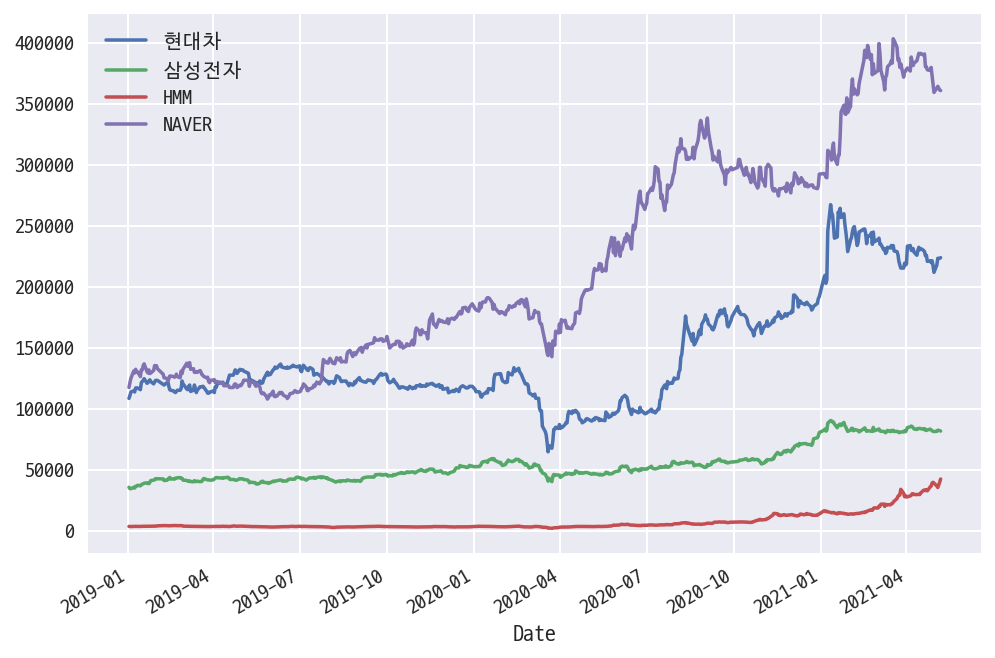

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# Loading ... Visualization Modules
import matplotlib.pyplot as plt
import warnings
plt.style.use('seaborn')
warnings.simplefilter(action='ignore', category=FutureWarning)

from matplotlib.font_manager import fontManager as fm # 한글폰트 확인 및 추가
font_list_check  = ['D2Coding', 'NanumGothicCoding', 'NanumGothic']
for _ in font_list_check:
    font_counts = [f  for f in font_list_check if _ in [_.name for _ in fm.ttflist]]
    if len(font_counts) > 1: print(f"found : {_}"); plt.rc('font', family=_); break 
        
data_df.plot()
plt.show()

## **02 파생데이터 생성하기**
연간/ 일간 수익률, 연간/ 일간 리스크

In [3]:
# 일간 수익률
daily_rate = data_df.pct_change()
daily_rate.head(3)

,현대차,삼성전자,HMM,NAVER
Date,,,,
2019-01-02,NaN,NaN,NaN,NaN
2019-01-03,0.021930,-0.029677,-0.021333,0.033898
2019-01-04,0.025751,-0.003989,-0.009537,0.028689


In [4]:
# 연간 수익률
annual_rate = daily_rate.mean() * 252   
annual_rate

현대차      0.400371
삼성전자     0.400616
HMM      1.207693
NAVER    0.553131
dtype: float64

In [5]:
# 일간 리스크 : 변동률의 공분산
daily_cov = daily_rate.cov()
daily_cov

,현대차,삼성전자,HMM,NAVER
현대차,0.000689,0.000241,0.000277,0.000168
삼성전자,0.000241,0.000318,0.000157,0.000131
HMM,0.000277,0.000157,0.001175,0.000114
NAVER,0.000168,0.000131,0.000114,0.000511


In [6]:
# 연간 리스크 : 일간 공분산 * 252
annual_cov = daily_cov * 252
annual_cov

,현대차,삼성전자,HMM,NAVER
현대차,0.173505,0.060639,0.069833,0.042260
삼성전자,0.060639,0.080155,0.039617,0.033036
HMM,0.069833,0.039617,0.296157,0.028783
NAVER,0.042260,0.033036,0.028783,0.128705


## **03 몬테카를로 시뮬레이션**
포트폴리오 20,000 개를 활용한 최적의 포트폴리오 비율 계산
$$포트폴리오 Risk = \sqrt{(종목별 비중)T((종목별 연간공분산) (종목별 비중))} $$

In [7]:
%%time
stocks = list(code_dict.values())
port_rate, port_risk, port_weights = [], [], [] 

# 몬테카를로 시뮬레이션
import numpy as np
for _ in range(20000): 
    weights = np.random.random(len(stocks)) 
    weights /= np.sum(weights) 

    returns = np.dot(weights, annual_rate) 
    risk = np.sqrt(np.dot(weights.T, np.dot(annual_cov, weights))) 

    port_rate.append(returns) 
    port_risk.append(risk) 
    port_weights.append(weights) 

CPU times: user 820 ms, sys: 3.25 ms, total: 823 ms
Wall time: 822 ms


In [8]:
# 포트폴리오의 수익률과 위험률 테이블로 정리
portfolio = {'Returns': port_rate, 'Risk': port_risk} 

# 기업별 비율을 적용하여 테이블 추가하기
for _, s in enumerate(stocks):
    portfolio[s] = [weight[_] for weight in port_weights]

portfolio_df = pd.DataFrame(portfolio) 
portfolio_df.tail(3)

,Returns,Risk,삼성전자,현대차,HMM,NAVER
19997,0.606950,0.261802,0.174601,0.358000,0.206384,0.261016
19998,0.754283,0.318046,0.271388,0.129569,0.400834,0.198210
19999,0.616938,0.278023,0.284162,0.138541,0.196078,0.381219


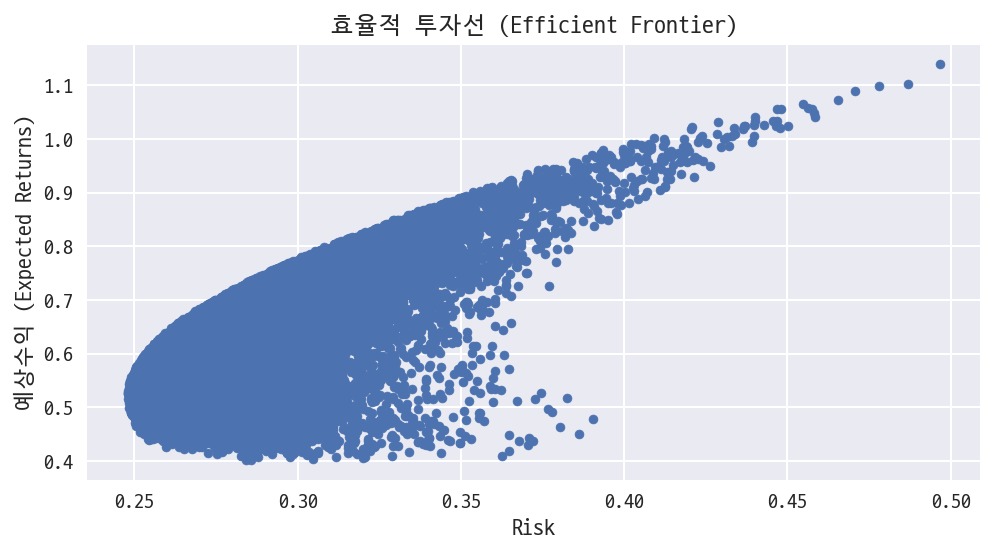

In [9]:
portfolio_df.plot.scatter(x='Risk', y='Returns', figsize=(8, 4), grid=True)
plt.title('효율적 투자선 (Efficient Frontier)') 
plt.xlabel('Risk') 
plt.ylabel('예상수익 (Expected Returns)') 
plt.show() 

# **2 샤프 지수와 포트폴리오 최적화**
## **01 샤프지수**
$ 사프지수 = {(포트폴리오 예상 수익률 - 무위험률) \over 수익률 표준편차} $

In [10]:
%%time
stocks = list(code_dict.values())
port_rate, port_risk, port_weights, sharpe_ratio = [], [], [], [] 

for _ in range(20000): 
    weights = np.random.random(len(stocks)) 
    weights /= np.sum(weights) 

    returns = np.dot(weights, annual_rate) 
    risk = np.sqrt(np.dot(weights.T, np.dot(annual_cov, weights))) 

    port_rate.append(returns) 
    port_risk.append(risk) 
    port_weights.append(weights)
    sharpe_ratio.append(returns/risk)

CPU times: user 843 ms, sys: 45.5 ms, total: 888 ms
Wall time: 847 ms


In [11]:
# Sharp 지수를 추가하여 시뮬레이션 실행
portfolio = {'Returns': port_rate, 'Risk': port_risk, 'Sharpe': sharpe_ratio}

for _, s in enumerate(stocks): 
    portfolio[s] = [weight[_] for weight in port_weights] 
portfolio_df = pd.DataFrame(portfolio)
portfolio_df.tail(3)

,Returns,Risk,Sharpe,삼성전자,현대차,HMM,NAVER
19997,0.678400,0.290727,2.333461,0.279911,0.136128,0.288421,0.295539
19998,0.676718,0.274002,2.469753,0.127922,0.295048,0.287411,0.289619
19999,0.654926,0.284588,2.301311,0.265249,0.102902,0.241396,0.390453


In [12]:
# 최대 리스크 포트폴리오
max_sharpe = portfolio_df.loc[portfolio_df['Sharpe'] == portfolio_df['Sharpe'].max()]
max_sharpe

,Returns,Risk,Sharpe,삼성전자,현대차,HMM,NAVER
19074,0.774323,0.299091,2.588917,0.004118,0.256057,0.398546,0.341279


In [13]:
# 최소 리스크 포트폴리오
min_risk   = portfolio_df.loc[portfolio_df['Risk'] == portfolio_df['Risk'].min()]
min_risk 

,Returns,Risk,Sharpe,삼성전자,현대차,HMM,NAVER
15617,0.515512,0.248044,2.07831,0.063955,0.55105,0.085851,0.299144


/home/buffet/Coding/Python/Pytorch/lib/python3.8/site-packages/pandas/plotting/_matplotlib/tools.py:400: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():


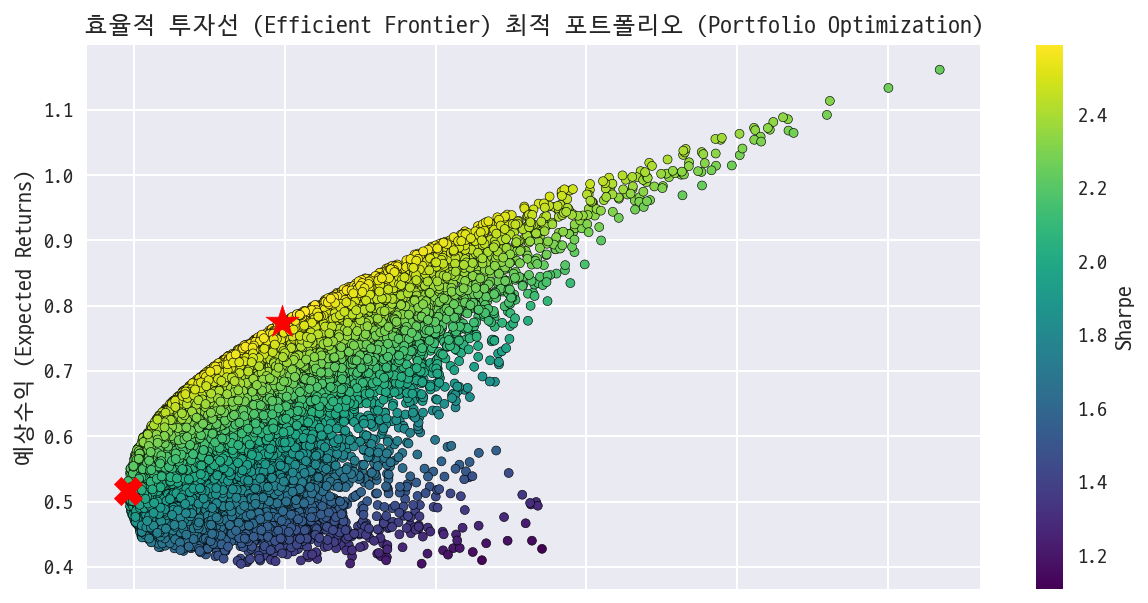

In [14]:
# 결과 시각화 출력하기
portfolio_df.plot.scatter(x='Risk', y='Returns', c='Sharpe', 
            cmap='viridis', edgecolors='k', figsize=(10,5), grid=True)

plt.scatter(x=max_sharpe['Risk'], y=max_sharpe['Returns'], 
            c='r', marker='*', s=300) # 최대 위험 / 수익구간
plt.scatter(x=min_risk['Risk'], y=min_risk['Returns'], 
            c='r', marker='X', s=200) # 최소 위험 / 수익구각
plt.title('효율적 투자선 (Efficient Frontier) 최적 포트폴리오 (Portfolio Optimization)') 
plt.xlabel('Risk') 
plt.ylabel('예상수익 (Expected Returns)') 
plt.show()